<a href="https://colab.research.google.com/github/galileo15640215/django/blob/master/imageai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
ｓ
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.21-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [5]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [6]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive

 AtcoderGetSchedule.gs.desktop	 ICPC	    写真		     旅行
'Colab Notebooks'		 ml_train   大学
 ES				 titanic    富士フイルムインターン


In [0]:
from PIL import Image
import os, glob
import numpy as np
from PIL import ImageFile
# IOError: image file is truncated (0 bytes not processed)回避のため
ImageFile.LOAD_TRUNCATED_IMAGES = True
DATADIR = "drive/ml_train"
classes = ["yamanotesenn", "keihinntouhokusenn", "chuosenn", "soubusenn", "keiyousenn", "toukaidousenn", "yokosukasenn", "700", "N700", "E4", "E5", "E6", "E7"]
names = ["山手線", "京浜東北線", "中央線", "総武線", "京葉線", "東海道線", "横須賀線", "７００", "Ｎ７００", "Ｅ４", "Ｅ５", "Ｅ６", "Ｅ７"]

num_classes = len(classes)
image_size = 64
num_testdata = 25

X_train = []
X_test  = []
y_train = []
y_test  = []

cnt = 0
for index, classlabel in enumerate(classes):
    photos_dir = DATADIR + "/" + classlabel
    print(photos_dir)
    files = glob.glob(photos_dir + "/*.jpg")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        """
        if i < num_testdata:
            X_test.append(data)
            y_test.append(index)
        else:
              X_train.append(data)
              y_train.append(index)
        cnt += 1
        print(cnt)
        """
        if i < num_testdata:
            X_test.append(data)
            y_test.append(index)
            cnt += 1
            print(cnt)
        else:
            for angle in range(-20, 20, 5):
                img_r = image.rotate(angle)
                data = np.asarray(img_r)
                X_train.append(data)
                y_train.append(index)
                img_trans = img_r.transpose(Image.FLIP_LEFT_RIGHT)
                data = np.asarray(img_trans)
                X_train.append(data)
                y_train.append(index)
                cnt += 1
                print(cnt)
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

xy = (X_train, X_test, y_train, y_test)
np.save("./ml_train.npy", xy)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import np_utils
import tensorflow.keras as keras
import numpy as np

num_classes = len(classes)
image_size = 64

"""
データを読み込む関数
"""
def load_data():
    X_train, X_test, y_train, y_test = np.load("./ml_train.npy", allow_pickle=True)
    # 入力データの各画素値を0-1の範囲で正規化(学習コストを下げるため)
    X_train = X_train.astype("float") / 255
    X_test  = X_test.astype("float") / 255
    # to_categorical()にてラベルをone hot vector化
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test  = np_utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_test, y_test

# データの読み込み
X_train, y_train, X_test, y_test = load_data()

X, y, X_test, y_test = X_train, y_train, X_test, y_test
model = Sequential()

# Xは(1200, 64, 64, 3)
# X.shape[1:]とすることで、(64, 64, 3)となり、入力にすることが可能です。
model.add(Conv2D(32,(3,3), padding='same',input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(Dense(len(classes)))
model.add(Activation('softmax'))

# https://keras.io/ja/optimizers/
# 今回は、最適化アルゴリズムにRMSpropを利用
#opt = keras.optimizers.rmsprop(lr=0.00005, decay=1e-6)
opt = keras.optimizers.RMSprop(lr=0.00005, decay=1e-6)
# https://keras.io/ja/models/sequential/
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
history = model.fit(X, y, batch_size=28, epochs=10)
# HDF5ファイルにKerasのモデルを保存
model.save('./cnn.h5')


Epoch 1/10
712/712 [==============================] - 389s 546ms/step - loss: 1.9669 - accuracy: 0.3327
Epoch 2/10
712/712 [==============================] - 386s 542ms/step - loss: 1.2839 - accuracy: 0.5778
Epoch 3/10
712/712 [==============================] - 387s 544ms/step - loss: 0.9359 - accuracy: 0.6958
Epoch 4/10
712/712 [==============================] - 387s 543ms/step - loss: 0.7210 - accuracy: 0.7679
Epoch 5/10
712/712 [==============================] - 387s 543ms/step - loss: 0.5519 - accuracy: 0.8231
Epoch 6/10
712/712 [==============================] - 388s 545ms/step - loss: 0.4158 - accuracy: 0.8677
Epoch 7/10
712/712 [==============================] - 388s 545ms/step - loss: 0.3150 - accuracy: 0.8990
Epoch 8/10
712/712 [==============================] - 389s 547ms/step - loss: 0.2322 - accuracy: 0.9265
Epoch 9/10
712/712 [==============================] - 389s 546ms/step - loss: 0.1812 - accuracy: 0.9421
Epoch 10/10
712/712 [==============================] - 389s 547m

In [23]:
results.tail(1)

,loss,accuracy
9,0.142408,0.953802


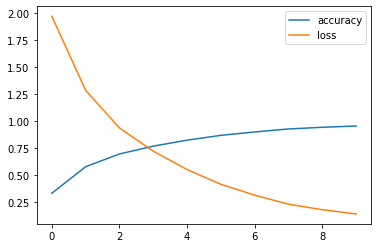

In [24]:
import pandas as pd
results = pd.DataFrame(history.history)
results[['accuracy', 'loss']].plot()


In [18]:
from google.colab import files
uploaded = files.upload()

Saving dennsha1.jpg to dennsha1.jpg


In [19]:
import tensorflow.keras
import sys, os
import numpy as np
from tensorflow.keras.models import load_model

imsize = (64, 64)

testpic     = "./dennsha1.jpg"
keras_param = "./cnn.h5"

def load_image(path):
    img = Image.open(path)
    img = img.convert('RGB')
    # 学習時に、(64, 64, 3)で学習したので、画像の縦・横は今回 変数imsizeの(64, 64)にリサイズします。
    img = img.resize(imsize)
    # 画像データをnumpy配列の形式に変更
    img = np.asarray(img)
    img = img / 255.0
    return img

if __name__ == "__main__":

    model = load_model(keras_param)
    img = load_image(testpic)
    prd = model.predict(np.array([img]))
    #print(prd) # 精度の表示
    for i in range(len(prd[0])):
      print('{:　<8}{:f}'.format(names[i], prd[0][i]))
    prelabel = np.argmax(prd, axis=1)
    for i in range(len(classes)):
      if prelabel == i:
        print(">>>"+names[i])


山手線　　　　　0.000283
京浜東北線　　　0.092020
中央線　　　　　0.000032
総武線　　　　　0.000120
京葉線　　　　　0.000012
東海道線　　　　0.000351
横須賀線　　　　0.000407
７００　　　　　0.000479
Ｎ７００　　　　0.000000
Ｅ４　　　　　　0.008634
Ｅ５　　　　　　0.111510
Ｅ６　　　　　　0.000034
Ｅ７　　　　　　0.786115
>>>Ｅ７
